In [286]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import os
import seaborn as sns

bs = 64 # batch size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [518]:
"""
LOAD MODEL GIVEN TRAINED WEIGHTS
gpu=True if GPU is available
"""
def load_model(model_dir, gpu=True):
    model = models.resnet34(pretrained=False)
    #model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 6)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 256),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(256, 6)
    )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    if(gpu):
        mode.load_state_dict(torch.load(model_dir))
    else:
        model.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
    
    return model


"""
Normalize input image with ImageNet Dataset mean and standard deviation
Input: RGB image - np.ndarray
Output: Normalized RGB image - np.ndarray
"""
def normalize_array(img):
    img = img[:,:,:3] # in case the input has 4 channels
    img = img/255. # put the value in range [0,1]
    img = (img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225]) # Normalization
    
    return img

"""
Normalize input image with ImageNet Dataset mean and standard deviation
Input: RGB image - np.ndarray
Output: Normalized RGB image - torch.tensor
"""
def normalize_tensor(img):
    img = img[:,:,:3] # in case the input has 4 channels
    img = img / 255. # put the value in range [0,1]
    img = torch.Tensor(img)
    img = (img - torch.Tensor([0.485, 0.456, 0.406])) / torch.Tensor([0.229, 0.224, 0.225]) # Normalization
    img = img.reshape(bs, img.shape[0],  img.shape[1], 3) # reshape from [H, W, C] to [N, H, W, C] 
    img = img.permute(0,3,1,2) # transpose from [N, H, W, C] to [N, C, H, W]
    img = img.to(device)
    
    return img

"""
Display the input ship image and the information of the image:
1) Resolution (by pixels)
2) Estimated actual length of the ship (in meters)

Input: img - the input image
Output: the display
"""
def display(img):
    plt.figure()
    plt.title("RESOLUTION: " + str(img.shape[0]) + " by " + str(img.shape[1]) + " pixels." 
              + "\n" + "SHIP LENGTH: "  + str((img.shape[0] * 2.5)) + " meters.")
    plt.imshow(img)
    
"""
Unroll multi-dimensinal features to a single dimension
[N, C, H, W] -> [N, C*H*W]
Input: t - A 4-D Tensor
Output: unrolled 2-D Tensor
"""    
def unroll_4D(t : torch.Tensor) -> torch.Tensor:
    t = t.reshape((t.shape[0]), t.shape[1] * t.shape[2] * t.shape[3])
    return t

In [530]:
"""
Pad the unrolled extracted feature tensor to match the expected number of neurons at the final convolutional layer
[]

Input: t - Input 2-D tensor dim = (N, C*H*W)
Input: num_neurons - Expected number of neurons in the final layer
Output: Padded Tensor
"""
def pad_feature(t:torch.Tensor, num_neurons) -> torch.Tensor:
    # Pad the last dimension to the right
    t = F.pad(t, pad = (0,num_neurons-t.shape[1]), mode = "constant", value=0) 
    
    return t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


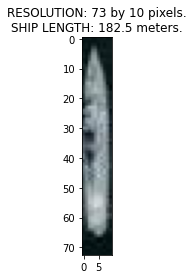

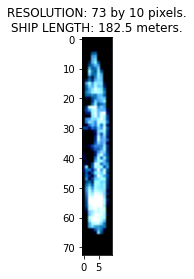

In [161]:
img = plt.imread("./Downloads/Sat2/Warship/war55_1.jpg")
img_norm = normalize_array(img)
display(img)
display(img_norm)

In [267]:
def pad2(img, target_length=224):
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_target = np.zeros((target_length, target_length, 3), np.uint8) #<-- use this to build datase
    copy_loc_h = (target_length-img_height) // 2
    copy_loc_w = (target_length-img_width) // 2
    img_target[copy_loc_h:copy_loc_h+img_height, copy_loc_w:copy_loc_w+img_width,:] = img

    return img_target

In [506]:
bs = 1
#img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Samples/Warship/2.5_flip_h_war55_1.jpg")
"""
Experiment to examine the convolution activations in deep layers
"""
def examine(img):
    model.eval()
    display(img)
    inp = normalize_tensor(img)

    def layer_0(inp):
        m = model.conv1(inp)
        m = model.bn1(m)
        m = model.relu(m)
        m = model.maxpool(m)

        return m

    def layer_1(inp):
        m = model.layer1(inp)
        return m

    def layer_2(inp):
        m = model.layer2(inp)
        return m

    def layer_3(inp):
        m = model.layer3(inp)
        return m

    def layer_4(inp):
        m = model.layer4(inp)
        return m

    out = layer_0(inp)
    out = layer_1(out)
    out = layer_2(out)
    out = layer_3(out)
    out = layer_4(out)
    out = model.maxpool(out)

    print("Result size: " + "Depth: " + str(out.shape[1]) + ", H: " + str(out.shape[2]) + " , W: " + str(out.shape[3]) + " pixels.")

    _out = out.detach().cpu().numpy()
    _out = _out.reshape(_out.shape[1], _out.shape[2], _out.shape[3])
    _out = _out.transpose(1,2,0)
    
    plt.figure()
    plt.imshow(_out[:,:,16])
    print(_out[:,:,16])
    
    return out

# for i in range(512):
# out = out.reshape((128,1))
# sns.heatmap(out)

In [534]:
model = load_model(model_dir = "./Downloads/Sat2/Models/Phase4_res34_fc512_256_6.pth", gpu=False)
model.layer4[1]
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Result size: Depth: 512, H: 3 , W: 1 pixels.
[[0.        ]
 [0.        ]
 [0.17499465]]
torch.Size([1, 1920])


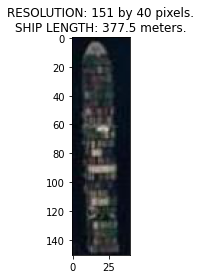

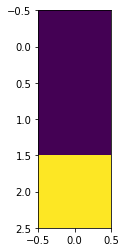

In [535]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Samples/Container/2.5_conn1_2.jpg")
out = examine(img)
out = unroll_4D(out)
out = pad_feature(out, num_neurons = 1920)
print(out.shape)

Input size: 121 by 31 pixels.
Result size: Depth: 512, H: 2 , W: 1 pixels.
[[0.47967607]
 [1.8360307 ]]


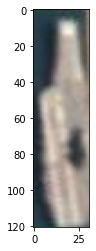

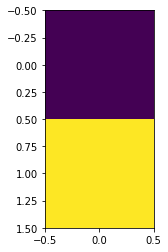

In [496]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Samples/Carrier/2.5_ca1.jpg")
examine(img)

Input size: 70 by 9 pixels.
Result size: Depth: 512, H: 2 , W: 1 pixels.
[[0.89033294]
 [2.0020363 ]]


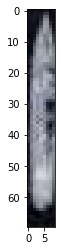

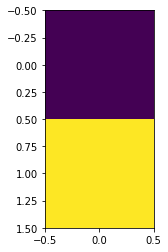

In [497]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Samples/Warship/2.5_flip_h_war55_1.jpg")
examine(img)

Input size: 123 by 29 pixels.
Result size: Depth: 512, H: 2 , W: 1 pixels.
[[0.56043994]
 [0.56043994]]


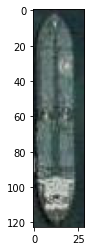

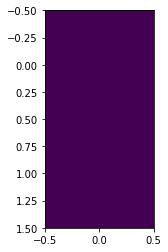

In [489]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Samples/Tanker/2.5_t8_3.jpg")
examine(img)

Input size: 33 by 12 pixels.
Result size: Depth: 256, H: 2 , W: 1 pixels.


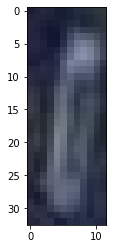

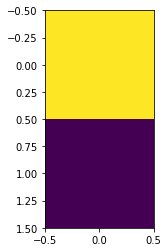

In [411]:
img = plt.imread("./Downloads/Sat2/Resolutions/Cropped-Samples/Bulk Carrier Small/2.5_rotated_h_bulks3_4.jpg")
examine(img)

In [456]:
model2 = models.mobilenet_v2(pretrained = False)
print(model2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr